In [26]:
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [52]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    
    plt.imshow(img_binary_lp)
    plt.show()
    print(img_binary_lp.shape)

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

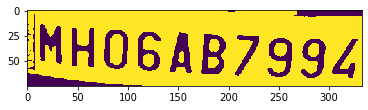

(75, 333)


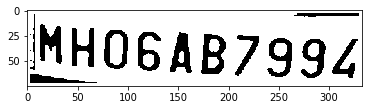

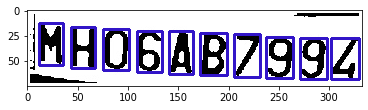

In [92]:
img = cv2.imread('w.jpg')
char = segment_characters(img)

(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)
(44, 24)


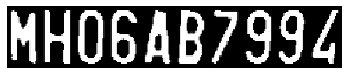

In [93]:
#import pytesseract
vis = char[0]
for i in range(1,10):
    vis = np.concatenate((vis,char[i]), axis=1)
    #char[i]=255-char[i] 
    plt.imshow(vis,cmap="gray")
    print(char[i].shape)
    plt.axis('off')
    #text=pytesseract.image_to_string(char[i], config="-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVXYZ --psm 6")
    #print(text)

(-0.5, 239.5, 43.5, -0.5)

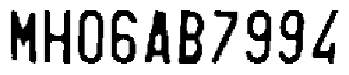

In [94]:
vis=255-vis
plt.imshow(vis,cmap='gray')
plt.axis('off')

### Model for characters

In [6]:
import tensorflow as tf
tf.enable_eager_execution()

c:\users\yash\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\yash\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\yash\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\yash\appdata\

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D, BatchNormalization
from tensorflow.keras import optimizers

In [14]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [15]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.992):
      self.model.stop_training = True

In [16]:
import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 295s 341ms/step - loss: 3.1674 - acc: 0.1725 - val_loss: 2.2788 - val_acc: 0.4907
Epoch 2/80
864/864 [==============================] - 297s 343ms/step - loss: 1.9804 - acc: 0.4745 - val_loss: 1.3936 - val_acc: 0.7130
Epoch 3/80
864/864 [==============================] - 301s 349ms/step - loss: 1.2902 - acc: 0.6412 - val_loss: 0.7836 - val_acc: 0.8241
Epoch 4/80
864/864 [==============================] - 284s 329ms/step - loss: 0.8263 - acc: 0.7593 - val_loss: 0.6057 - val_acc: 0.8519
Epoch 5/80
864/864 [==============================] - 272s 314ms/step - loss: 0.7065 - acc: 0.7905 - val_loss: 0.4756 - val_acc: 0.9074
Epoch 6/80
864/864 [==============================] - 270s 312ms/step - loss: 0.4653 - acc: 0.8727 - val_loss: 0.4052 - val_acc: 0.8889
Epoch 7/80
864/864 [==============================] - 604s 699ms/step - loss: 0.4441 - acc: 0.8588 - val_loss: 0.3566 - val_acc: 0.8796
Epoch 8/80
864/864 [============================

Epoch 39/80
864/864 [==============================] - 310s 359ms/step - loss: 0.0877 - acc: 0.9745 - val_loss: 0.0917 - val_acc: 0.9815
Epoch 40/80
864/864 [==============================] - 281s 325ms/step - loss: 0.0591 - acc: 0.9792 - val_loss: 0.0583 - val_acc: 0.9676
Epoch 41/80
864/864 [==============================] - 299s 346ms/step - loss: 0.0767 - acc: 0.9745 - val_loss: 0.0640 - val_acc: 0.9769
Epoch 42/80
864/864 [==============================] - 304s 352ms/step - loss: 0.0692 - acc: 0.9769 - val_loss: 0.0655 - val_acc: 0.9815
Epoch 43/80
864/864 [==============================] - 272s 315ms/step - loss: 0.0556 - acc: 0.9792 - val_loss: 0.0895 - val_acc: 0.9769
Epoch 44/80
864/864 [==============================] - 285s 329ms/step - loss: 0.0607 - acc: 0.9792 - val_loss: 0.0441 - val_acc: 0.9907
Epoch 45/80
864/864 [==============================] - 256s 297ms/step - loss: 0.0543 - acc: 0.9826 - val_loss: 0.0430 - val_acc: 0.9815
Epoch 46/80
864/864 [====================

In [18]:
model.save_weights('model1.h5')

In [19]:
# !kill 8400
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard module is not an IPython extension.


UsageError: Line magic function `%tensorboard` not found.


In [20]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

MKR3DK2REE


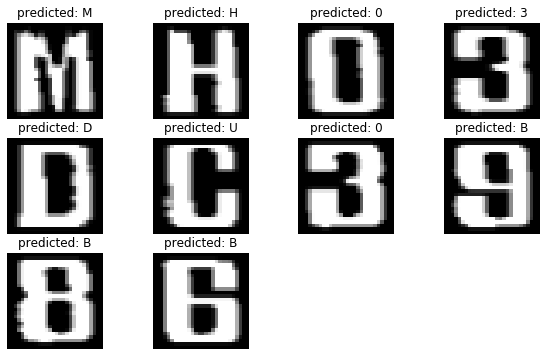

In [24]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()